# Feb 28, Mar31, 2024: correlation matrices (functional networks)
modified: [../feb24/01c-desc-func_nws.ipynb](../feb24/01c-desc-func_nws.ipynb)

In [1]:
import csv
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp 
import pickle 
from os.path import join as pjoin
from itertools import product
from tqdm import tqdm
from copy import deepcopy
from pathlib import Path
import subprocess
from scipy import sparse, stats
from multiprocessing import Pool
import glob

# networks
import graph_tool.all as gt

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow

plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr  # CITE ITS PAPER IN YOUR MANUSCRIPT

# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

In [3]:
args.type = 'spatial'
args.roi_size = 225
args.maintain_symmetry = True
args.brain_div = 'whl'
args.num_rois = 162

DESC = (
    f'type-{args.type}'
    f'_size-{args.roi_size}'
    f'_symm-{args.maintain_symmetry}'
    f'_braindiv-{args.brain_div}'
    f'_nrois-{args.num_rois}'
)

args.unit = 'seswise' # runwise/seswise/subwise : unit sample of dataset
args.denst = 25 # density of fc matrix

BASE_path = f'{os.environ["HOME"]}/mouse_dataset/roi_results'
TS_path = f'{BASE_path}/{DESC}/roi_timeseries'
FC_path = f'{BASE_path}/{DESC}/{args.unit}/correlation_graph/density-{args.denst}/corr_mats'
os.system(f'mkdir -p {FC_path}')

0

In [4]:
def create_dataframe(files):
    def get_ts(file):
        ts = np.loadtxt(file)
        ts = stats.zscore(ts, axis=0, nan_policy='omit')
        return ts        

    dataset_df = []

    for file in tqdm(files):
        ssr = file.split('/')[-1].split('_')
        sub, ses, run = [ssr[i].split('-')[-1] for i in range(3)]
        ts = get_ts(file)
        # fc = get_fc(ts)
        df = pd.DataFrame({
            'sub':[int(sub[-2:])],
            'ses':[int(ses)],
            'run':[int(run)],
            'ssr':[ssr[:-1]],
            'ts':[ts],
        })
        dataset_df.append(df)
        # save_fc(fc, ssr)
        
    dataset_df = pd.concat(dataset_df)
    dataset_df = dataset_df.sort_values(
        by=['sub', 'ses', 'run'],
    ).reset_index(drop=True)
    return dataset_df

In [5]:
dataset_df = create_dataframe(files=glob.glob(f'{TS_path}/*', recursive=True))

100%|██████████| 116/116 [00:00<00:00, 129.62it/s]


In [6]:
dataset_df.head()

,sub,ses,run,ssr,ts
0,1,1,1,"[sub-SLC01, ses-1, run-1, task-rest]","[[1.2065445520382525, 0.31730566969513757, 1.1..."
1,1,1,3,"[sub-SLC01, ses-1, run-3, task-rest]","[[-0.5547378628216872, -0.5207262140571332, 1...."
2,1,1,5,"[sub-SLC01, ses-1, run-5, task-rest]","[[0.862277562935586, -0.967577475923794, -2.33..."
3,1,1,7,"[sub-SLC01, ses-1, run-7, task-rest]","[[-1.3039578270123324, -0.44559813175695007, -..."
4,1,2,1,"[sub-SLC01, ses-2, run-1, task-rest]","[[1.1127898226126984, -1.3683128014437655, -2...."


In [7]:
all_cols = ['sub', 'ses', 'run']
cols = []
idx = [i for i, c in enumerate(all_cols) if args.unit[:3] in c][0]
cols = [c for i, c in enumerate(all_cols) if i <= idx]
cols

['sub', 'ses']

In [8]:
def make_ssr(cols, key):
    d = []
    for c, k in zip(cols, key):
        if 'sub' in c:
            d.append(f'{c}-SLC{k:02d}')
        else:
            d.append(f'{c}-{k}')
    return d

def get_fc(args, ts):
    fc = np.corrcoef(ts, rowvar=False)
    fc = fc[np.tril_indices(fc.shape[0], k=-1)]
    fc[np.isnan(fc)] = 0.0
    fc = fc > np.percentile(fc, q=100-args.denst) # this removes neg. edges
    
    fc_ = np.zeros((args.num_rois, args.num_rois))
    fc_[np.tril_indices(fc_.shape[0], k=-1)] = fc
    fc_ = (fc_ + fc_.T)
    return fc_

def make_graph(fc):
        fc = np.tril(fc)
        edges = np.where(fc)
        edge_list = list(zip(*[*edges, fc[edges]]))
        g = gt.Graph(
            edge_list, 
            eprops=[('weight', 'double')],
            directed=False,
        )
        return g

def save_graph(g, ssr):
    file = '_'.join(ssr + ['desc-corr-mat.gt.gz'])
    file = f'{FC_path}/{file}'
    g.save(file)
    return file

def create_graphs_df(args, dataset_df):
    graphs_df = []
    for key, group in tqdm(dataset_df.groupby(by=cols)):
        key = key if type(key) == tuple else (key,)
        ssr = make_ssr(cols, key)
        ts = np.concatenate(group['ts'].to_list(), axis=0)
        fc = get_fc(args, ts)
        g = make_graph(fc)
        file = save_graph(g, ssr)
        
        df = pd.DataFrame({})
        for s in ssr:
            c, k = s.split('-')
            df[c] = [k]
        df['graph'] = [g]
        df['file'] = [file]
        
        graphs_df.append(df)

    graphs_df = pd.concat(graphs_df).reset_index(drop=True)
    return graphs_df

In [9]:
graphs_df = create_graphs_df(args, dataset_df)
graphs_df.head()

100%|██████████| 30/30 [00:00<00:00, 90.23it/s]


,sub,ses,graph,file
0,SLC01,1,"<Graph object, undirected, with 162 vertices a...",/home/govindas/mouse_dataset/roi_results/type-...
1,SLC01,2,"<Graph object, undirected, with 162 vertices a...",/home/govindas/mouse_dataset/roi_results/type-...
2,SLC01,3,"<Graph object, undirected, with 162 vertices a...",/home/govindas/mouse_dataset/roi_results/type-...
3,SLC02,1,"<Graph object, undirected, with 162 vertices a...",/home/govindas/mouse_dataset/roi_results/type-...
4,SLC02,2,"<Graph object, undirected, with 162 vertices a...",/home/govindas/mouse_dataset/roi_results/type-...


<Axes: >

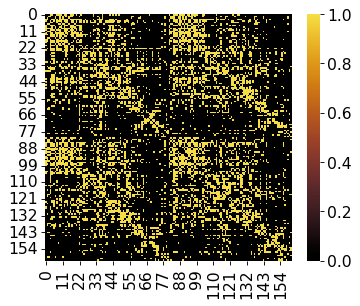

In [10]:
row = graphs_df.iloc[19]
g = row['graph']
fig, axs = plt.subplots(1, 1, figsize=(5, 4), dpi=80)
ax = axs
sns.heatmap(gt.adjacency(g).todense(), ax=ax, square=True, cmap=cmr.iceburn, center=0)

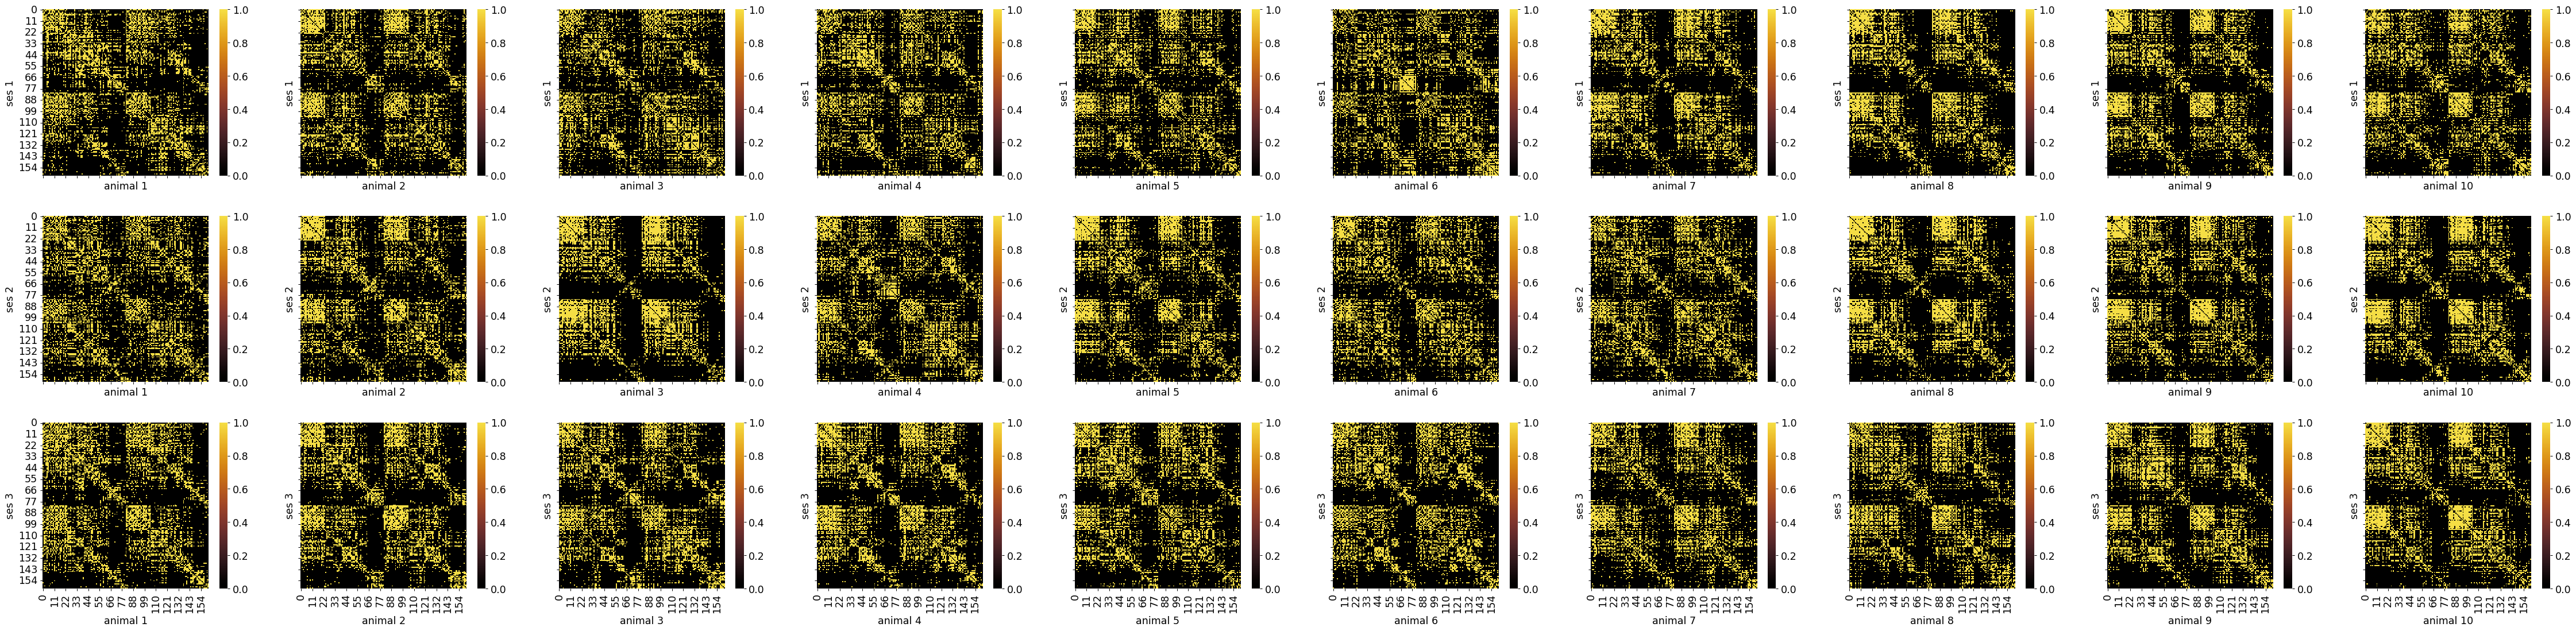

In [11]:
ncols = 10 
nrows=3
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows), dpi=90, sharex=True, sharey=True)
fig.tight_layout(h_pad=3, w_pad=3)

for idx, row in graphs_df.iterrows():
    sub, ses = row[['sub', 'ses']]
    sub = int(sub[-2:])
    ses = int(ses)
    
    ax = axs[ses-1, sub-1]
    g = row['graph']
    sns.heatmap(gt.adjacency(g).todense(), ax=ax, square=True, cmap=cmr.iceburn, center=0)
    ax.set(ylabel=f'ses {ses}', xlabel=f'animal {sub}')